In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn

In [8]:
# Import cifar-10 dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [9]:
train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

cifar_val_x = torch.empty((3, 32, 32, len(cifar10_val)), device=device)
cifar_val_y = torch.empty(len(cifar10_val), dtype=torch.long, device=device)

for i, (img, label) in enumerate(cifar10_val):
    cifar_val_x[:, :, :, i] = img
    cifar_val_y[i] = label

cifar_val_x = cifar_val_x.view(3, -1)

Files already downloaded and verified
Files already downloaded and verified


In [16]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_val=None, Y_pred=None):
        if Y_val is None:
            Y_val = self.last_val
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_val, torch.Tensor):
            Y_val = Y_val.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision': precision_score(Y_val, Y_pred, average='weighted'),
            'recall': recall_score(Y_val, Y_pred, average='weighted'),
            'f1': f1_score(Y_val, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_val, Y_pred),
            'classification_report': classification_report(Y_val, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
    def plot_training(self, title: str):
        loss_hist = self.train_loss_hist.cpu().detach().numpy()
        accuracy_hist = self.train_accuracy_hist.cpu().detach().numpy()
        validation_accuracy_hist = self.validation_accuracy_hist.cpu().detach().numpy()
        
        fig, ax = plt.subplots(1,2, sharex=True)
        fig.suptitle(title)
        ax[0].set_title('Training Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].plot(loss_hist, label='Training Loss')
        
        
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(accuracy_hist, label='Training Accuracy')
        ax[1].plot(validation_accuracy_hist, label='Validation Accuracy')
        
        plt.legend()
        plt.show()
    def plot_confusion_matrix(self, title):
        if self.last_results is None:
            self.get_results()
        cm = self.last_results['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        disp.ax_.set_title(title)
        
        
        
        
        
                
    
import time
from math import floor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PerceptronClassifier(Classifier):
    def __init__(self, input_dim=0, output_dim = 0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        self.stack_list = [nn.Flatten(), nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.append(nn.Linear(hidden_layers[-1], output_dim))
        self.stack = nn.Sequential(*self.stack_list)
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs: int,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        alpha: float,
        loss_fn: nn.Module = nn.CrossEntropyLoss(),
        optimizer: nn.Module = torch.optim.SGD,
        print_epoch: int = 10,
        **optimizer_kwargs,
    ):
        self.train_loss_hist = torch.zeros(epochs).to(device)
        self.train_accuracy_hist = torch.zeros(epochs).to(device)
        self.validation_accuracy_hist = torch.zeros(epochs).to(device)
        
        
        optimizer = optimizer(self.parameters(), lr=alpha, **optimizer_kwargs)
        training_time = 0
        for epoch in range(epochs):
            self.train()
            
            start_time = time.time()
            train_loss = 0
            train_correct = torch.zeros(1).to(device)
            
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                train_correct += (Y_pred.argmax(dim=1) == Y_batch).sum()
            training_time += time.time() - start_time
            
            self.train_accuracy_hist[epoch] = train_correct/len(train_loader.dataset)
            self.train_loss_hist[epoch] = train_loss/len(train_loader)
            
            val_correct = torch.zeros(1).to(device)
            self.eval()
            with torch.no_grad():
                Y_pred_eval = torch.zeros(len(test_loader.dataset)).to(device)
                
                idx = 0
                for X_val_batch, Y_val_batch in test_loader:
                    X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
                    batch_size = X_val_batch.size(0)
                    Y_pred = self.predict(X_val_batch)
                    Y_pred_eval[idx:idx + batch_size] = Y_pred
                    val_correct += (Y_pred == Y_val_batch).sum()
                    idx += batch_size
                    
                self.validation_accuracy_hist[epoch] = val_correct/len(test_loader.dataset)
            epoch_time = time.time() - start_time
            
                    
                
        
            if epoch % print_epoch == 0:
                rem_time = (epochs - epoch)*epoch_time / 60
                rem_time_str = f'{floor(rem_time):02}:{floor((rem_time - floor(rem_time))*60):02}'
                print(f'Epoch {epoch}: Training Loss: {(train_loss/len(train_loader))}, Training Accuracy: {(train_correct/len(train_loader.dataset)).item()}, Validation Accuracy: {(val_correct/len(test_loader.dataset)).item()}, Estimated Time Remaining: {rem_time_str}')
        self.last_pred = torch.tensor(Y_pred_eval)
        self.last_val = torch.tensor(test_loader.dataset.targets)
        print(f'\nTraining Time: {training_time} seconds\n')

            
            


Using device: cuda


In [17]:

retrain = True

if retrain:
    perceptron = PerceptronClassifier(input_dim=3*32*32, hidden_layers=[64, 32, 16], output_dim=10).to(device=device)
    perceptron.train_model(
    epochs=20,
    train_loader=train_loader,
    test_loader=test_loader,
    alpha=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.SGD,
    print_epoch=1
    )
    pickle = torch.save(perceptron, 'models/perceptron.pt')
else:
    perceptron = torch.load('models/perceptron.pt')


Epoch 0: Training Loss: 2.1362294754408815, Training Accuracy: 0.22181999683380127, Validation Accuracy: 0.32409998774528503, Estimated Time Remaining: 04:33
Epoch 1: Training Loss: 1.8034886542488546, Training Accuracy: 0.36267998814582825, Validation Accuracy: 0.3929999768733978, Estimated Time Remaining: 04:24
Epoch 2: Training Loss: 1.660103644708843, Training Accuracy: 0.41025999188423157, Validation Accuracy: 0.42989999055862427, Estimated Time Remaining: 04:03
Epoch 3: Training Loss: 1.5792360875917517, Training Accuracy: 0.43733999133110046, Validation Accuracy: 0.4381999969482422, Estimated Time Remaining: 03:53
Epoch 4: Training Loss: 1.5201180719048775, Training Accuracy: 0.460239976644516, Validation Accuracy: 0.45229998230934143, Estimated Time Remaining: 03:39
Epoch 5: Training Loss: 1.4707046645071806, Training Accuracy: 0.47665998339653015, Validation Accuracy: 0.4599999785423279, Estimated Time Remaining: 03:25
Epoch 6: Training Loss: 1.4265798912633716, Training Accur

Accuracy: 0.4943
Precision: 0.4920968349842192
Recall: 0.4943
F1: 0.48919611600760515
Confusion_matrix:
[[562  51  63  28  49  17  27  28 104  71]
 [ 52 632  12  14   8   9  31   9  64 169]
 [ 92  16 303  85 173 106 125  48  20  32]
 [ 24  29  51 275  87 225 186  50  24  49]
 [ 66  11 107  33 363  68 206  92  33  21]
 [ 18  10  65 180  67 430 107  71  18  34]
 [  7  25  48  52  92  53 667  12  19  25]
 [ 31  22  41  75  78 112  37 520  10  74]
 [135  82   9  30  27  18  17   7 596  79]
 [ 43 177  12  34   9  16  42  31  41 595]]
Classification_report:
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      1000
           1       0.60      0.63      0.62      1000
           2       0.43      0.30      0.35      1000
           3       0.34      0.28      0.30      1000
           4       0.38      0.36      0.37      1000
           5       0.41      0.43      0.42      1000
           6       0.46      0.67      0.55      1000
         

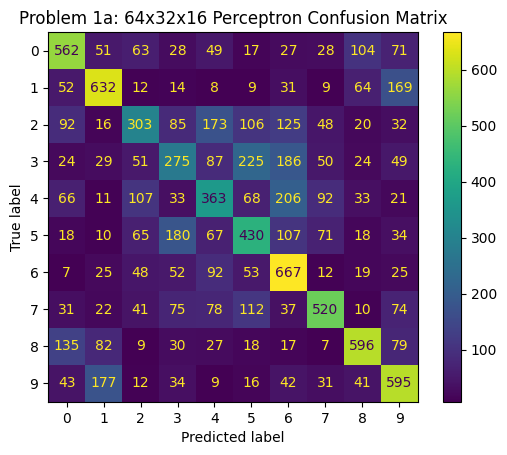

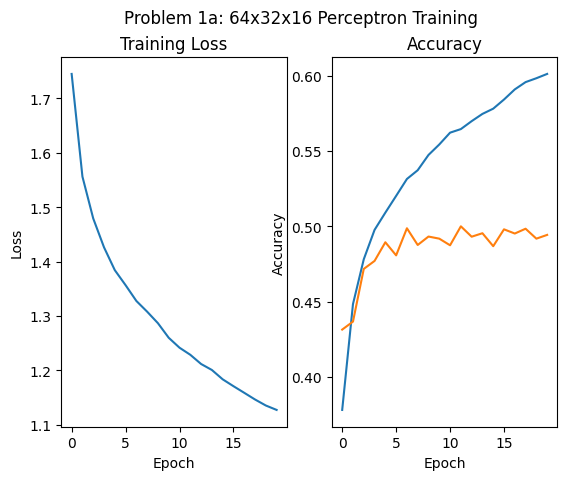

In [14]:
perceptron.print_results()
perceptron.plot_confusion_matrix('Problem 1a: 64x32x16 Perceptron Confusion Matrix')

perceptron.plot_training('Problem 1a: 64x32x16 Perceptron Training')

In [15]:
retrain_complex = True

if retrain_complex:
    complex_perceptron = PerceptronClassifier(input_dim=3*32*32, hidden_layers=[256, 128, 64, 32, 16], output_dim=10).to(device=device)
    complex_perceptron.train_model(
        epochs=20,
        train_loader=train_loader,
        test_loader=test_loader,
        alpha=0.01,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam,
        print_epoch=1
    )
    torch.save(complex_perceptron, 'models/complex_perceptron.pt')
    
else:
    complex_perceptron = torch.load('models/complex_perceptron.pt')

complex_perceptron.print_results()
complex_perceptron.plot_confusion_matrix('Problem 1b: 256x128x64x32x16 Perceptron Confusion Matrix')
complex_perceptron.plot_training('Problem 1b: 256x128x64x32x16 Perceptron Training')
Classifier.compare_results(complex_perceptron.get_results(), perceptron.get_results())


Epoch 0: Training Loss: 1.9478040133290888, Training Accuracy: 0.2502799928188324, Validation Accuracy: 0.2798999845981598, "Estimated Time Remaining: 5.009595553080241 minutes
Epoch 1: Training Loss: 1.8659216404875831, Training Accuracy: 0.2772199809551239, Validation Accuracy: 0.28540000319480896, "Estimated Time Remaining: 4.933139582475026 minutes
Epoch 2: Training Loss: 1.8329031961348357, Training Accuracy: 0.2968599796295166, Validation Accuracy: 0.28209999203681946, "Estimated Time Remaining: 4.664214849472046 minutes
Epoch 3: Training Loss: 1.8360515703325686, Training Accuracy: 0.29179999232292175, Validation Accuracy: 0.2800000011920929, "Estimated Time Remaining: 4.37841561237971 minutes
Epoch 4: Training Loss: 1.8466362169636485, Training Accuracy: 0.2829599976539612, Validation Accuracy: 0.28630000352859497, "Estimated Time Remaining: 4.29164129892985 minutes
Epoch 5: Training Loss: 1.881327116733317, Training Accuracy: 0.27629998326301575, Validation Accuracy: 0.2829000

KeyboardInterrupt: 

In [ ]:
complex_perceptron.print_results()
complex_perceptron.plot_confusion_matrix('Problem 1b: 256x128x64x32x16 Perceptron Confusion Matrix')
complex_perceptron.plot_training('Problem 1b: 256x128x64x32x16 Perceptron Training')
Classifier.compare_results(complex_perceptron.get_results(), perceptron.get_results())